<a href="https://colab.research.google.com/github/duckmaster22/setwithfriends/blob/main/APMA2070_final_project_HZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib.colorbar import ColorbarBase
from scipy.interpolate import griddata
import joblib  # For loading scalers

torch.autograd.set_detect_anomaly(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# For predicting omega
class AuxNetwork(nn.Module):
   def __init__(self, hidden_layers=[20, 20, 20, 20, 20, 20, 20]):
       super(AuxNetwork, self).__init__()

       # Input layer
       self.input_layer = nn.Linear(3, hidden_layers[0])

       # Hidden layers
       self.hidden_layers = nn.ModuleList()
       for i in range(len(hidden_layers) - 1):
           self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))

       # Output layer
       self.output_layer = nn.Linear(hidden_layers[-1], 1)

       # tanh activation
       self.activation = nn.Tanh()

   def forward(self, t, x, y):
       inputs = torch.cat([t, x, y], dim=1)

       if not isinstance(inputs, torch.Tensor):
           inputs = torch.tensor(inputs, dtype=torch.float32, device=device)

       a = self.activation(self.input_layer(inputs))
       for layer in self.hidden_layers:
           a = self.activation(layer(a))

       return self.output_layer(a)

class CoupledNavierStokesPINN(nn.Module):
   def __init__(self, hidden_layers=[20, 20, 20, 20, 20, 20, 20, 20]):
       super(CoupledNavierStokesPINN, self).__init__()
       # Input layer
       self.input_layer = nn.Linear(3, hidden_layers[0])  # (t, x, y)
       # Hidden layers (8x20)
       self.hidden_layers = nn.ModuleList()
       for i in range(len(hidden_layers) - 1):
           self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
       self.output_layer = nn.Linear(hidden_layers[-1], 4)

       # omega prediction
       self.aux_network = AuxNetwork(hidden_layers=[20, 20, 20, 20, 20, 20, 20])

       # tanh activation
       self.activation = nn.Tanh()

       # Initialize weights
       self.apply(self._init_weights)

       # Set constants
       self.rho = 1.0          # Density
       self.mu = 0.1           # Viscosity
       self.lambda_ = 4.2428e-5 # Cohesive stress parameter
       self.tau = 1e-6         # Relaxation parameter
       self.h = 0.05           # Interface length
       self.gamma = 1.0        # Parameter for g(φ) term

       self.kf_true = 0.5 # actual kappa
       # set kappa
       self.permeability_params = nn.ParameterDict({'kappa': nn.Parameter(torch.tensor(0.3, device=device))})

       # all weights = 1
       self.omega_pde = torch.tensor(1.0, device=device)
       self.omega_ic = torch.tensor(1.0, device=device)
       self.omega_bc = torch.tensor(1.0, device=device)
       self.omega_data = torch.tensor(1.0, device=device)

       # Adam optimizer
       self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

       # learning scheduler
       #self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.9, patience=500, verbose=True)

   def _init_weights(self, module):
       if isinstance(module, nn.Linear):
           nn.init.kaiming_normal_(module.weight, nonlinearity='tanh')
           if module.bias is not None:
               nn.init.zeros_(module.bias)

   def forward(self, x):
       if not isinstance(x, torch.Tensor):
           x = torch.tensor(x, dtype=torch.float32, device=device)

       t = x[:, 0:1]
       x_coords = x[:, 1:2]
       y_coords = x[:, 2:3]

       # Forward pass through main network
       a = self.activation(self.input_layer(x))
       for layer in self.hidden_layers:
           a = self.activation(layer(a))

       output = self.output_layer(a)

       u = output[:, 0:1]
       v = output[:, 1:2]
       p = output[:, 2:3]
       phi = output[:, 3:4]
       omega = self.aux_network(t, x_coords, y_coords)

       return u, v, p, phi, omega

   def compute_derivatives(self, t, x, y, outputs):
       """Compute spatial and temporal derivatives of the outputs"""
       inputs = torch.cat([t, x, y], dim=1).requires_grad_(True)
       t = t.detach().requires_grad_(True)
       x = x.detach().requires_grad_(True)
       y = y.detach().requires_grad_(True)

       # Forward pass
       u, v, p, phi, omega = self.forward(inputs)

       try:
           u_grad = torch.autograd.grad(outputs=u.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           u_t, u_x, u_y = u_grad[:, 0:1], u_grad[:, 1:2], u_grad[:, 2:3]

           v_grad = torch.autograd.grad(outputs=v.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           v_t, v_x, v_y = v_grad[:, 0:1], v_grad[:, 1:2], v_grad[:, 2:3]

           p_grad = torch.autograd.grad(outputs=p.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           p_x, p_y = p_grad[:, 1:2], p_grad[:, 2:3]

           phi_grad = torch.autograd.grad(outputs=phi.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           phi_t, phi_x, phi_y = phi_grad[:, 0:1], phi_grad[:, 1:2], phi_grad[:, 2:3]

           omega_grad = torch.autograd.grad(outputs=omega.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           omega_x, omega_y = omega_grad[:, 1:2], omega_grad[:, 2:3]

           u_xx = torch.autograd.grad(outputs=u_x.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 1:2]
           u_yy = torch.autograd.grad(outputs=u_y.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 2:3]
           v_xx = torch.autograd.grad(outputs=v_x.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 1:2]
           v_yy = torch.autograd.grad(outputs=v_y.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 2:3]

           phi_xx = torch.autograd.grad(outputs=phi_x.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           phi_yy = torch.autograd.grad(outputs=phi_y.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]
           phi_xy = torch.autograd.grad(outputs=phi_x.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0]

           omega_xx = torch.autograd.grad(outputs=omega_x.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 1:2]
           omega_yy = torch.autograd.grad(outputs=omega_y.sum(), inputs=inputs, create_graph=True, retain_graph=True, allow_unused=True)[0][:, 2:3]

       except Exception as e:
           print(f"Error in compute_derivatives: {str(e)}")

       # return derivatives dict
       derivatives = {
           'u_t': u_t, 'u_x': u_x, 'u_y': u_y,
           'v_t': v_t, 'v_x': v_x, 'v_y': v_y,
           'p_x': p_x, 'p_y': p_y,
           'phi_t': phi_t, 'phi_x': phi_x, 'phi_y': phi_y,
           'omega_x': omega_x, 'omega_y': omega_y,
           'u_xx': u_xx, 'u_yy': u_yy,
           'v_xx': v_xx, 'v_yy': v_yy,
           'phi_xx': phi_xx, 'phi_yy': phi_yy, 'phi_xy': phi_xy,
           'omega_xx': omega_xx, 'omega_yy': omega_yy
       }

       return derivatives

   def compute_pde_residuals(self, t, x, y):
       # forward pass
       inputs = torch.cat([t, x, y], dim=1)
       u, v, p, phi, omega = self.forward(inputs)

       # check output
       if torch.isnan(u).any() or torch.isnan(v).any() or torch.isnan(p).any() or torch.isnan(phi).any() or torch.isnan(omega).any():
           print("NaN detected in network outputs")
           zero = torch.zeros_like(u)
           return {
               'f_u': zero,
               'f_v': zero,
               'f_cont': zero,
               'f_phi': zero,
               'f_omega': zero
           }

       derivatives = self.compute_derivatives(t, x, y, (u, v, p, phi, omega))

       u_t, u_x, u_y = derivatives['u_t'], derivatives['u_x'], derivatives['u_y']
       v_t, v_x, v_y = derivatives['v_t'], derivatives['v_x'], derivatives['v_y']
       p_x, p_y = derivatives['p_x'], derivatives['p_y']
       phi_t, phi_x, phi_y = derivatives['phi_t'], derivatives['phi_x'], derivatives['phi_y']

       u_xx, u_yy = derivatives['u_xx'], derivatives['u_yy']
       v_xx, v_yy = derivatives['v_xx'], derivatives['v_yy']
       phi_xx, phi_yy, phi_xy = derivatives['phi_xx'], derivatives['phi_yy'], derivatives['phi_xy']
       omega_xx, omega_yy = derivatives['omega_xx'], derivatives['omega_yy']

       # physical constants
       rho = self.rho
       mu = self.mu
       lambda_ = self.lambda_
       tau = self.tau
       h = self.h
       gamma = self.gamma

       # get kappa
       kappa = torch.abs(self.permeability_params['kappa'])

       # 2D laplacians
       lap_u = u_xx + u_yy
       lap_v = v_xx + v_yy
       lap_phi = phi_xx + phi_yy
       lap_omega = omega_xx + omega_yy

       # 2D advection terms
       u_adv = u*u_x + v*u_y
       v_adv = u*v_x + v*v_y
       phi_adv = u*phi_x + v*phi_y

       # clip phi?
       #phi_clipped = torch.clamp(phi, min=-1.0, max=1.0)
       g_phi = phi * (phi**2 - 1) / (h**2)

        # div of viscous stress
       div_sigma_vis_x = mu * lap_u
       div_sigma_vis_y = mu * lap_v

        # div of cohesive stress
       div_sigma_coh_x = lambda_ * (phi_xx * phi + phi_x * phi_x + phi_xy * phi + phi_y * phi_x)
       div_sigma_coh_y = lambda_ * (phi_xy * phi + phi_x * phi_y + phi_yy * phi + phi_y * phi_y)

       # momentum equation x eq. 1
       f_u = rho * (u_t + u_adv) + p_x - div_sigma_coh_x - div_sigma_coh_x + mu * ((1 - phi) * u) / (2 * kappa)

       # momentum equation y eq. 1
       f_v = rho * (v_t + v_adv) + p_y - div_sigma_coh_y - div_sigma_coh_y + mu * ((1 - phi) * v) / (2 * kappa)

       # Continuity equation eq. 2
       f_cont = u_x + v_y

       # Cahn-Hilliard eq. 3
       f_phi = phi_t + phi_adv - tau * lap_omega

       # Chemical potential eq. 4
       f_omega = omega - lap_phi - gamma * g_phi

       residuals = {
           'f_u': f_u,
           'f_v': f_v,
           'f_cont': f_cont,
           'f_phi': f_phi,
           'f_omega': f_omega
       }
       # error detection
       for key, val in residuals.items():
           if torch.isnan(val).any():
               print(f"NaN detected in {key} residual")
               residuals[key] = torch.zeros_like(val)

       return residuals

   def compute_bc_residuals(self, t_bc, x_bc, y_bc):
          try:
              # forward pass for BC points
              inputs_bc = torch.cat([t_bc, x_bc, y_bc], dim=1)
              u_bc, v_bc, p_bc, phi_bc, omega_bc = self.forward(inputs_bc)

              # Find the min/max values to identify boundaries
              x_min = x_bc.min().item()
              x_max = x_bc.max().item()
              y_min = y_bc.min().item()
              y_max = y_bc.max().item()

              # Use tolerance-based detection for boundaries
              x_inlet_tolerance = 0.1
              x_outlet_tolerance = 0.1
              y_wall_tolerance = 0.1

              # Initialize all residual values with default tensors
              zero = torch.zeros(1, 1, device=device)
              u_inlet_res = zero.clone()
              v_inlet_res = zero.clone()
              u_wall_res = zero.clone()
              v_wall_res = zero.clone()

              # Neumann BCs velocity + pressure outlet
              u_outlet_res = zero.clone()
              v_outlet_res = zero.clone()
              p_outlet_res = zero.clone()

              # For phi and omega Neumann BCs on all boundaries
              phi_inlet_res = zero.clone()
              omega_inlet_res = zero.clone()
              phi_outlet_res = zero.clone()
              omega_outlet_res = zero.clone()
              phi_top_wall_res = zero.clone()
              omega_top_wall_res = zero.clone()
              phi_bottom_wall_res = zero.clone()
              omega_bottom_wall_res = zero.clone()

              # ---------------- INLET BCs ----------------
              # Identify inlet boundary (x ≈ x_min)
              inlet_mask = (torch.abs(x_bc - x_min) < x_inlet_tolerance).squeeze()
              if torch.any(inlet_mask):
                  inlet_points = torch.cat([t_bc[inlet_mask], x_bc[inlet_mask], y_bc[inlet_mask]], dim=1)
                  # x around -1.7, scaled
                  # Dirichlet BCs for velocity at inlet
                  y_bc_inlet = y_bc[inlet_mask]
                  y_normalized = (y_bc_inlet - y_min) / (y_max - y_min + 1e-10) * 2
                  u_inlet_target = 0.3 * (y_normalized) * (y_normalized - 2)
                  v_inlet_target = torch.ones_like(y_bc_inlet)
                  u_phys_min = -0.3
                  u_phys_max = 0
                  u_inlet_target_scaled = 2.0 * (u_inlet_target - u_phys_min) / (u_phys_max - u_phys_min) - 1.0
                  #v_inlet_target_scaled = 2.0 * (v_inlet_target - u_phys_min) / (u_phys_max - u_phys_min) - 1.0

                  u_inlet_res = u_bc[inlet_mask] - u_inlet_target_scaled
                  v_inlet_res = v_bc[inlet_mask] - v_inlet_target

                  # Neumann BCs for phi and omega at inlet (∂φ/∂n = ∂ω/∂n = 0, where n = -x)
                  inlet_inputs = inlet_points.clone().requires_grad_(True)
                  _, _, _, phi_inlet, omega_inlet = self.forward(inlet_inputs)

                  # Calculate x derivatives (negative of normal derivative at inlet)
                  try:
                      phi_x_inlet = torch.autograd.grad(phi_inlet.sum(), inlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]
                      omega_x_inlet = torch.autograd.grad(omega_inlet.sum(), inlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]

                      # Neumann condition: gradient in normal direction should be zero
                      phi_inlet_res = phi_x_inlet  # normal is -x, so we want -phi_x = 0 => phi_x = 0
                      omega_inlet_res = omega_x_inlet
                  except Exception as e:
                      print(f"Error computing inlet Neumann conditions: {str(e)}")
              else:
                  print("Warning: No inlet boundary points detected.")

              # ---------------- WALL BCs ----------------
              # Identify top and bottom walls
              top_wall_mask = (torch.abs(y_bc - y_max) < y_wall_tolerance).squeeze()
              bottom_wall_mask = (torch.abs(y_bc - y_min) < y_wall_tolerance).squeeze()
              wall_mask = top_wall_mask | bottom_wall_mask

              # No-slip Dirichlet BCs for velocity at walls
              if torch.any(wall_mask):
                  u_wall_res = u_bc[wall_mask]  # u = 0 at walls
                  v_wall_res = v_bc[wall_mask]  # v = 0 at walls

                  # Separate processing for top and bottom walls for Neumann BCs
                  # Top wall: normal is +y
                  if torch.any(top_wall_mask):
                      top_wall_points = torch.cat([t_bc[top_wall_mask], x_bc[top_wall_mask], y_bc[top_wall_mask]], dim=1)
                      top_wall_inputs = top_wall_points.clone().requires_grad_(True)
                      _, _, _, phi_top, omega_top = self.forward(top_wall_inputs)

                      try:
                          phi_y_top = torch.autograd.grad(phi_top.sum(), top_wall_inputs, create_graph=True, retain_graph=True)[0][:, 2:3]
                          omega_y_top = torch.autograd.grad(omega_top.sum(), top_wall_inputs, create_graph=True, retain_graph=True)[0][:, 2:3]

                          # Neumann condition: gradient in normal direction should be zero
                          phi_top_wall_res = phi_y_top  # normal is +y
                          omega_top_wall_res = omega_y_top
                      except Exception as e:
                          print(f"Error computing top wall Neumann conditions: {str(e)}")

                  # Bottom wall: normal is -y
                  if torch.any(bottom_wall_mask):
                      bottom_wall_points = torch.cat([t_bc[bottom_wall_mask], x_bc[bottom_wall_mask], y_bc[bottom_wall_mask]], dim=1)
                      bottom_wall_inputs = bottom_wall_points.clone().requires_grad_(True)
                      _, _, _, phi_bottom, omega_bottom = self.forward(bottom_wall_inputs)

                      try:
                          phi_y_bottom = torch.autograd.grad(phi_bottom.sum(), bottom_wall_inputs, create_graph=True, retain_graph=True)[0][:, 2:3]
                          omega_y_bottom = torch.autograd.grad(omega_bottom.sum(), bottom_wall_inputs, create_graph=True, retain_graph=True)[0][:, 2:3]

                          # Neumann condition: gradient in normal direction should be zero
                          phi_bottom_wall_res = -phi_y_bottom  # normal is -y, so we want phi_y = 0
                          omega_bottom_wall_res = -omega_y_bottom
                      except Exception as e:
                          print(f"Error computing bottom wall Neumann conditions: {str(e)}")
              else:
                  print("Warning: No wall boundary points detected.")

              # ---------------- OUTLET BCs ----------------
              # Outlet boundary (x ≈ x_max)
              outlet_mask = (torch.abs(x_bc - x_max) < x_outlet_tolerance).squeeze()

              if torch.any(outlet_mask):
                  outlet_points = torch.cat([t_bc[outlet_mask], x_bc[outlet_mask], y_bc[outlet_mask]], dim=1)
                  outlet_inputs = outlet_points.clone().requires_grad_(True)

                  # Forward pass for outlet points
                  u_outlet, v_outlet, p_outlet, phi_outlet, omega_outlet = self.forward(outlet_inputs)

                  # Compute x derivatives (normal at outlet is +x)
                  try:
                      u_x_outlet = torch.autograd.grad(u_outlet.sum(), outlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]
                      v_x_outlet = torch.autograd.grad(v_outlet.sum(), outlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]
                      p_x_outlet = torch.autograd.grad(p_outlet.sum(), outlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]
                      phi_x_outlet = torch.autograd.grad(phi_outlet.sum(), outlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]
                      omega_x_outlet = torch.autograd.grad(omega_outlet.sum(), outlet_inputs, create_graph=True, retain_graph=True)[0][:, 1:2]

                      # Neumann conditions at outlet (all gradients in normal direction should be zero)
                      u_outlet_res = u_x_outlet
                      v_outlet_res = v_x_outlet
                      p_outlet_res = p_x_outlet
                      phi_outlet_res = phi_x_outlet
                      omega_outlet_res = omega_x_outlet
                  except Exception as e:
                      print(f"Error computing outlet Neumann conditions: {str(e)}")
              else:
                  print("Error: no outlet boundary points detected")

              # Combine all BC residuals
              bc_residuals = {
                  # Dirichlet BCs
                  'u_inlet_res': u_inlet_res,
                  'v_inlet_res': v_inlet_res,
                  'u_wall_res': u_wall_res,
                  'v_wall_res': v_wall_res,

                  #Neumann BCs
                  'u_outlet_res': u_outlet_res,
                  'v_outlet_res': v_outlet_res,
                  'p_outlet_res': p_outlet_res,

                  'phi_inlet_res': phi_inlet_res,
                  'omega_inlet_res': omega_inlet_res,
                  'phi_outlet_res': phi_outlet_res,
                  'omega_outlet_res': omega_outlet_res,
                  'phi_top_wall_res': phi_top_wall_res,
                  'omega_top_wall_res': omega_top_wall_res,
                  'phi_bottom_wall_res': phi_bottom_wall_res,
                  'omega_bottom_wall_res': omega_bottom_wall_res
              }

              return bc_residuals

          except Exception as e:
              print(f"Error in compute_bc_residuals: {str(e)}")
              import traceback
              traceback.print_exc()


   def compute_loss(self, X_pde, X_bc, X_ic, X_data):
       try:
           t_pde, x_pde, y_pde = X_pde[:, 0:1], X_pde[:, 1:2], X_pde[:, 2:3]
           t_bc, x_bc, y_bc = X_bc[:, 0:1], X_bc[:, 1:2], X_bc[:, 2:3]
           t_ic, x_ic, y_ic = X_ic[:, 0:1], X_ic[:, 1:2], X_ic[:, 2:3]
           t_data, x_data, y_data = X_data[:, 0:1], X_data[:, 1:2], X_data[:, 2:3]

           # Data values for all data points
           u_data = X_data[:, 3:4]
           v_data = X_data[:, 4:5]
           #print(f'u_data_min={u_data.min().item()}')
           #print(f'u_data_max={u_data.max().item()}')
           #print(f'v_data_min={v_data.min().item()}')
           #print(f'v_data_max={v_data.max().item()}')
           p_data = X_data[:, 5:6]
           phi_data = X_data[:, 6:7]

           # PDE residuals
           pde_residuals = self.compute_pde_residuals(t_pde, x_pde, y_pde)

           # Calculate PDE loss
           L_pde_raw = (
               torch.mean(pde_residuals['f_u']**2) +
               torch.mean(pde_residuals['f_v']**2) +
               torch.mean(pde_residuals['f_cont']**2) +
               torch.mean(pde_residuals['f_phi']**2) +
               torch.mean(pde_residuals['f_omega']**2)
           ) #/25000

           # BC residuals
           bc_residuals = self.compute_bc_residuals(t_bc, x_bc, y_bc)

           L_bc_raw = 0.0
           try:
                # Dirichlet velocity conditions
                if bc_residuals['u_inlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['u_inlet_res']**2)
                if bc_residuals['v_inlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['v_inlet_res']**2)
                if bc_residuals['u_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['u_wall_res']**2)
                if bc_residuals['v_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['v_wall_res']**2)

                # Neumann conditions at outlet for velocity and pressure
                if bc_residuals['u_outlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['u_outlet_res']**2)
                if bc_residuals['v_outlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['v_outlet_res']**2)
                if bc_residuals['p_outlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['p_outlet_res']**2)

                # Neumann conditions
                # Inlet
                if bc_residuals['phi_inlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['phi_inlet_res']**2)
                if bc_residuals['omega_inlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['omega_inlet_res']**2)

                # Outlet
                if bc_residuals['phi_outlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['phi_outlet_res']**2)
                if bc_residuals['omega_outlet_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['omega_outlet_res']**2)

                # Top wall
                if bc_residuals['phi_top_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['phi_top_wall_res']**2)
                if bc_residuals['omega_top_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['omega_top_wall_res']**2)

                # Bottom wall
                if bc_residuals['phi_bottom_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['phi_bottom_wall_res']**2)
                if bc_residuals['omega_bottom_wall_res'].numel() > 0:
                    L_bc_raw += torch.mean(bc_residuals['omega_bottom_wall_res']**2)
           except Exception as e:
                print(f"Error computing BC loss: {str(e)}")
                L_bc_raw = torch.tensor(0.0, device=device)

           #L_bc_raw = L_bc_raw / 1000

           # IC loss
           # Forward pass at initial points
           u_ic_pred, v_ic_pred, p_ic_pred, phi_ic_pred, omega_ic_pred = self.forward(
               torch.cat([t_ic, x_ic, y_ic], dim=1)
           )

           # For proper initial conditions, find data points at t=t_min
           with torch.no_grad():
               t_min = t_data.min()
               t_min_mask = torch.isclose(t_data, t_min, rtol=1e-3, atol=1e-3)

               # If we have data points at t_min, create a lookup for IC targets
               if torch.any(t_min_mask):
                   # Extract initial data
                   x_t0 = x_data[t_min_mask]
                   y_t0 = y_data[t_min_mask]
                   u_t0 = u_data[t_min_mask]
                   v_t0 = v_data[t_min_mask]

                   # For each IC point, find the closest data point at t_min
                   u_ic_target = torch.zeros_like(u_ic_pred)
                   v_ic_target = torch.zeros_like(v_ic_pred)

                   # Simple approach: For each IC point, find matching data point
                   for i in range(len(x_ic)):
                       # Calculate distances to all t0 points
                       dx = x_ic[i] - x_t0
                       dy = y_ic[i] - y_t0
                       distances = torch.sqrt(dx**2 + dy**2)

                       # Find closest point
                       closest_idx = torch.argmin(distances)

                       # Assign target values
                       u_ic_target[i] = u_t0[closest_idx]
                       v_ic_target[i] = v_t0[closest_idx]
               else:
                   # Use first snapshot otherwise
                   print("No data points at t_min found. Using first snapshot for IC targets")
                   snapshot_idx = 0
                   t_first = torch.unique(t_data)[snapshot_idx]
                   t_first_mask = torch.isclose(t_data, t_first, rtol=1e-3, atol=1e-3)

                   x_t0 = x_data[t_first_mask]
                   y_t0 = y_data[t_first_mask]
                   u_t0 = u_data[t_first_mask]
                   v_t0 = v_data[t_first_mask]

                   # For each IC point, find the closest data point in first snapshot
                   u_ic_target = torch.zeros_like(u_ic_pred)
                   v_ic_target = torch.zeros_like(v_ic_pred)

                   # Simple approach: For each IC point, find matching data point
                   for i in range(len(x_ic)):
                       # Calculate distances to all t0 points
                       dx = x_ic[i] - x_t0
                       dy = y_ic[i] - y_t0
                       distances = torch.sqrt(dx**2 + dy**2)

                       # Find closest point
                       closest_idx = torch.argmin(distances)

                       # Assign target values
                       u_ic_target[i] = u_t0[closest_idx]
                       v_ic_target[i] = v_t0[closest_idx]

           # Calculate IC loss
           L_ic_raw = (
               torch.mean((u_ic_pred - u_ic_target)**2) +
               torch.mean((v_ic_pred - v_ic_target)**2)
            ) #/1000

           # Data loss
           # Forward pass at data points
           u_pred, v_pred, p_pred, phi_pred, omega_pred = self.forward(
               torch.cat([t_data, x_data, y_data], dim=1)
           )

           # Calculate L_data loss
           L_data_raw = (
               torch.mean((u_pred - u_data)**2) +
               torch.mean((v_pred - v_data)**2) +
               torch.mean((p_pred - p_data)**2) +
               torch.mean((phi_pred - phi_data)**2)
           ) #/35000

           # Calculate total loss with current weights
           total_loss = (
               self.omega_pde * L_pde_raw +
               self.omega_bc * L_bc_raw +
               self.omega_ic * L_ic_raw +
               self.omega_data * L_data_raw
           )

           # Check for NaN in losses
           if torch.isnan(total_loss):
               print("NaN in loss")
               print(f"L_pde: {L_pde_raw.item()}, L_bc: {L_bc_raw.item()}, L_ic: {L_ic_raw.item()}, L_data: {L_data_raw.item()}")
               print(f"Weights: pde={self.omega_pde.item()}, bc={self.omega_bc.item()}, ic={self.omega_ic.item()}, data={self.omega_data.item()}")

               return (
                   torch.tensor(1.0, device=device, requires_grad=True),
                   torch.tensor(0.25, device=device),
                   torch.tensor(0.25, device=device),
                   torch.tensor(0.25, device=device),
                   torch.tensor(0.25, device=device)
               )

           return total_loss, L_pde_raw, L_bc_raw, L_ic_raw, L_data_raw

       except Exception as e:
           print(f"Error in compute_loss: {str(e)}")
           import traceback
           traceback.print_exc()
           return (
               torch.tensor(1.0, device=device, requires_grad=True),
               torch.tensor(0.25, device=device),
               torch.tensor(0.25, device=device),
               torch.tensor(0.25, device=device),
               torch.tensor(0.25, device=device)
           )

   def _compute_grad_norm(self, dummy_var):
       total_norm = 0
       for param in self.parameters():
           if param.grad is not None:
               param_norm = param.grad.data.norm(2)
               total_norm += param_norm.item() ** 2
       total_norm = torch.tensor(total_norm ** 0.5, device=device)
       return total_norm

   def train_model(self, X_pde, X_bc, X_ic, X_data, epochs, tolerance):
       losses = []
       best_loss = float('inf')
       patience = 1000
       patience_counter = 0

       permeability_history = []
       weight_history = []

       # For monitoring relative L2 error
       prev_l2_error = float('inf')

       clip_value = 1.0

       # Data-only training period
       data_only_phase = 100

       for epoch in range(epochs):
           # Train only on data
           if epoch < data_only_phase:
               orig_pde_weight = self.omega_pde.item()
               self.omega_pde = torch.tensor(0.0, device=device)

               self.optimizer.zero_grad()
               loss, L_pde, L_bc, L_ic, L_data = self.compute_loss(X_pde, X_bc, X_ic, X_data)

               if not torch.isnan(loss):
                   loss.backward()
                   torch.nn.utils.clip_grad_norm_(self.parameters(), clip_value)
                   self.optimizer.step()

               # Reset PDE weights
               if epoch == data_only_phase - 1:
                   print("Switching from data-only to full physics-informed training")
                   # Reset PDE weight to 1
                   self.omega_pde = torch.tensor(1.0, device=device)
           else:
               # Add physics-informed training
               self.optimizer.zero_grad()

               # Use a subset of PDE points for preventing memory issues
               pde_indices = torch.randperm(X_pde.size(0))[:2000]
               X_pde_batch = X_pde[pde_indices]

               loss, L_pde, L_bc, L_ic, L_data = self.compute_loss(X_pde_batch, X_bc, X_ic, X_data)
               loss.backward()
               torch.nn.utils.clip_grad_norm_(self.parameters(), clip_value)
               self.optimizer.step()

               # Update learning rate
               #self.scheduler.step(loss)

           # Track permeability and weights
           with torch.no_grad():
               kappa = torch.abs(self.permeability_params['kappa']).item()
               permeability_history.append((epoch, kappa))
               weight_history.append((epoch, self.omega_pde.item(), self.omega_bc.item(), self.omega_ic.item(), self.omega_data.item()))

           # Calculate relative L2 error for monitoring
           with torch.no_grad():
               # Evaluate the model on data points
               t_data, x_data, y_data = X_data[:, 0:1], X_data[:, 1:2], X_data[:, 2:3]
               u_data, v_data = X_data[:, 3:4], X_data[:, 4:5]

               u_pred, v_pred, _, _, _ = self.forward(torch.cat([t_data, x_data, y_data], dim=1))

               # Velocity norm
               vel_ref = torch.sqrt(u_data**2 + v_data**2 + 1e-8)
               vel_pred = torch.sqrt(u_pred**2 + v_pred**2 + 1e-8)

               # Relative L2 error with safe computation
               error_tensor = vel_pred - vel_ref
               numerator = torch.norm(error_tensor)
               denominator = torch.norm(vel_ref)

               if denominator > 1e-8:
                   l2_error = numerator / denominator
               else:
                   l2_error = numerator

               # Check relative improvement
               rel_change = abs(l2_error - prev_l2_error) / (prev_l2_error + 1e-8)
               prev_l2_error = l2_error.item()

           if not torch.isnan(loss):
               # Store losses, L2 error, and dynamic weights
               losses.append([epoch, loss.item(), L_pde.item(), L_bc.item(),L_ic.item(), L_data.item(), l2_error.item(),self.omega_pde.item(), self.omega_bc.item(), self.omega_ic.item(), self.omega_data.item()])

               if epoch % 10 == 0:
                   print(f"Epoch {epoch}: Loss = {loss.item():.4e}, L2 Error = {l2_error.item():.4e}, Change = {rel_change:.4e}")
                   #print(f"Weights: PDE={self.omega_pde.item():.4e}, BC={self.omega_bc.item():.4e}, " + f"IC={self.omega_ic.item():.4e}, Data={self.omega_data.item():.4e}")
                   print(f"Loss Components: PDE={L_pde.item():.4e}, BC={L_bc.item():.4e}, IC={L_ic.item():.4e}, Data={L_data.item():.4e}")
                   print(f"Permeability κ = {kappa:.4e} (True: 0.5)")
                   print("\n")

                   #curr_lr = self.optimizer.param_groups[0]['lr']
                   #print(f"Current learning rate: {curr_lr:.2e}")

               # Check convergence using L2 error
               if (l2_error < tolerance):
                   print(f"Converged at epoch {epoch} with L2 error {l2_error.item():.4e} < tolerance {tolerance}")
                   break


               # Early stopping based on loss improvement
               if loss.item() < best_loss:
                   best_loss = loss.item()
                   patience_counter = 0
               else:
                   patience_counter += 1

               if patience_counter > patience:
                   print(f"Early stopping at epoch {epoch}: no improvement for {patience} epochs")
                   break

       # Convert history arrays to numpy for plotting
       permeability_history = np.array(permeability_history)
       weight_history = np.array(weight_history)

       # Return all training history
       return np.array(losses) if losses else np.array([[0, 1.0, 0.25, 0.25, 0.25, 0.25, 1.0]]), permeability_history, weight_history

   def infer_permeability(self, X_data):
       try:
           # Trained permeability value
           kappa_normalized = torch.abs(self.permeability_params['kappa']).item()
           permeability_value = kappa_normalized

           # Extract phase field data
           t_data, x_data, y_data = X_data[:, 0:1], X_data[:, 1:2], X_data[:, 2:3]
           phi_data = X_data[:, 6:7] if X_data.shape[1] > 6 else None

           with torch.no_grad():
               _, _, _, phi_pred, _ = self.forward(torch.cat([t_data, x_data, y_data], dim=1))

           # Count number of "core" and "shell" points based on phase data
           core_mask = (phi_pred < -0.5)  # -1 in the core
           shell_mask = (phi_pred > -0.5) & (phi_pred < 0.5)  # φ = 0 in the outer shell

           #print(f"Learned normalized permeability value: {kappa_normalized:.6f}")
           print(f"Learned permeability value: {permeability_value:.6f}")
           print(f"True permeability value: {self.kf_true:.6f}")
           print(f"Relative error: {abs(permeability_value - self.kf_true)/self.kf_true*100:.2f}%")
           print(f"Rough # core points: {torch.sum(core_mask).item()}, shell points: {torch.sum(shell_mask).item()}")

           # For now, using the same permeability value for core and shell
           return {
               'overall': permeability_value,
               'normalized': kappa_normalized,
               'true': self.kf_true,
               'relative_error': abs(permeability_value - self.kf_true)/self.kf_true
           }

       except Exception as e:
           print(f"Error in infer_permeability: {str(e)}")

   def predict(self, t_test, x_test, y_test):
       # Convert inputs to tensors if not already
       if not isinstance(t_test, torch.Tensor):
           t_test = torch.tensor(t_test, dtype=torch.float32, device=device)
           x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
           y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

       # Ensure proper dimensions
       if t_test.dim() == 1:
           t_test = t_test.unsqueeze(1)
       if x_test.dim() == 1:
           x_test = x_test.unsqueeze(1)
       if y_test.dim() == 1:
           y_test = y_test.unsqueeze(1)

       # Forward pass
       with torch.no_grad():
           inputs = torch.cat([t_test, x_test, y_test], dim=1)
           u, v, p, phi, omega = self.forward(inputs)

       # Return predictions as numpy arrays
       return {
           'u': u.cpu().numpy(),
           'v': v.cpu().numpy(),
           'p': p.cpu().numpy(),
           'phi': phi.cpu().numpy(),
           'omega': omega.cpu().numpy()
       }

def calculate_l2(pred, true):
   error = pred - true
   error_norm = np.sqrt(np.sum(error**2))
   true_norm = np.sqrt(np.sum(true**2))

   # Check if the true norm is very small or zero
   if true_norm < 1e-10:
       # Return absolute error instead if true values are close to zero
       return error_norm
   else:
       # Return relative error
       return error_norm / true_norm
def plot_results(model, x_scaler, y_scaler, test_data, epoch, save_dir='results'):
   # Create save directory if it doesn't exist
   os.makedirs(save_dir, exist_ok=True)

   # Extract test data
   X_test = test_data[:, 0:3]  # [t, x, y]
   Y_test = test_data[:, 3:]   # [u, v, p, phi]

   # Inverse transform scaled data
   X_test_original = x_scaler.inverse_transform(X_test)
   Y_test_original = y_scaler.inverse_transform(Y_test)

   # Make predictions
   t_test = torch.tensor(X_test[:, 0:1], dtype=torch.float32, device=device)
   x_test = torch.tensor(X_test[:, 1:2], dtype=torch.float32, device=device)
   y_test = torch.tensor(X_test[:, 2:3], dtype=torch.float32, device=device)
   predictions = model.predict(t_test, x_test, y_test)

   # Prepare the predictions for inverse scaling
   Y_pred = np.hstack((
       predictions['u'],
       predictions['v'],
       predictions['p'],
       predictions['phi']
   ))

   # Inverse transform predictions
   Y_pred_original = y_scaler.inverse_transform(Y_pred)

   u_pred = Y_pred_original[:, 0]
   v_pred = Y_pred_original[:, 1]
   p_pred = Y_pred_original[:, 2]
   phi_pred = Y_pred_original[:, 3]

   u_test = Y_test_original[:, 0]
   v_test = Y_test_original[:, 1]
   p_test = Y_test_original[:, 2]
   phi_test = Y_test_original[:, 3]

   u_error = np.abs(u_pred - u_test)
   v_error = np.abs(v_pred - v_test)
   p_error = np.abs(p_pred - p_test)
   phi_error = np.abs(phi_pred - phi_test)

   u_l2 = calculate_l2(u_pred, u_test)
   v_l2 = calculate_l2(v_pred, v_test)
   p_l2 = calculate_l2(p_pred, p_test)
   phi_l2 = calculate_l2(phi_pred, phi_test)

   print(f"Relative L2 errors at epoch {epoch}:")
   print(f"u: {u_l2:.4e}")
   print(f"v: {v_l2:.4e}")
   print(f"p: {p_l2:.4e}")
   print(f"phi: {phi_l2:.4e}")

   # Plot velocity magnitude
   vel_mag_test = np.sqrt(u_test**2 + v_test**2)
   vel_mag_pred = np.sqrt(u_pred**2 + v_pred**2)

   # Create plots for snapshot comparison
   t_unique = np.unique(X_test_original[:, 0])

  # For each time value, create plots
   for t_val in t_unique:
        # For loading scalers
        # Find points at this time
        t_mask = np.isclose(X_test_original[:, 0], t_val, atol=1e-2)

        # Extract x-y coordinates and values for this time
        x_coords = X_test_original[t_mask, 1]
        y_coords = X_test_original[t_mask, 2]
        phi_t_pred = phi_pred[t_mask]

        # Skip if not t = 0.30
        if not np.isclose(t_val, 0.30, atol=1e-2):
            continue

        print(f"Create contour plot for t = {t_val:.2f}")

        # Use fixed domain bounds
        x_min, x_max = 0.0, 6.0  # Adjust based on your actual domain
        y_min, y_max = 0.0, 2.0

        grid_size = 200
        xi = np.linspace(x_min, x_max, grid_size)
        yi = np.linspace(y_min, y_max, grid_size)
        X, Y = np.meshgrid(xi, yi)

        Z = griddata((x_coords, y_coords), phi_t_pred, (X, Y), method='nearest')

        fig = plt.figure(figsize=(10, 4))

        left_margin = 0.1
        right_margin = 0.1
        top_margin = 0.1
        bottom_margin = 0.2
        plot_width = 1.0 - left_margin - right_margin
        plot_height = 0.7

        main_ax = fig.add_axes([left_margin, bottom_margin + 0.15, plot_width, plot_height])
        cmap = plt.cm.coolwarm
        norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
        contour = main_ax.contourf(X, Y, Z, 100, cmap=cmap, norm=norm)
        main_ax.set_aspect('equal')
        main_ax.set_xticks([])
        main_ax.set_yticks([])
        main_ax.set_xticklabels([])
        main_ax.set_yticklabels([])

        for spine in main_ax.spines.values():
            spine.set_visible(False)

        main_ax.set_title(r'$\phi_{{pred}}$', fontsize=20)
        cbar_ax = fig.add_axes([left_margin, bottom_margin, plot_width, 0.05])
        cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_ticks(np.linspace(-1.0, 1.0, 5))
        cb.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])
        plt.savefig(os.path.join(save_dir, f'phi_prediction_t_{t_val:.2f}.png'), dpi=300, bbox_inches='tight')
        plt.close()

   # Return errors
   return {
       'u_l2': u_l2,
       'v_l2': v_l2,
       'p_l2': p_l2,
       'phi_l2': phi_l2
   }
def plot_training_history(losses, permeability_history, weight_history, save_dir='results'):
   os.makedirs(save_dir, exist_ok=True)

   # Plot loss during training
   plt.figure(figsize=(12, 8))
   plt.semilogy(losses[:, 0], losses[:, 1], label='Total Loss')
   plt.semilogy(losses[:, 0], losses[:, 2], label='PDE Loss')
   plt.semilogy(losses[:, 0], losses[:, 3], label='BC Loss')
   plt.semilogy(losses[:, 0], losses[:, 4], label='IC Loss')
   plt.semilogy(losses[:, 0], losses[:, 5], label='Data Loss')
   plt.xlabel('Epoch')
   plt.ylabel('Loss (log scale)')
   plt.legend()
   plt.grid(True, which="both", ls="--")
   plt.title('Loss Evolution during Training')
   plt.savefig(os.path.join(save_dir, 'loss_history.png'), dpi=300)
   plt.close()

   # Plot weights evolution
   #plt.figure(figsize=(12, 6))
   #plt.plot(weight_history[:, 0], weight_history[:, 1], label='PDE Weight')
   #plt.plot(weight_history[:, 0], weight_history[:, 2], label='BC Weight')
   #plt.plot(weight_history[:, 0], weight_history[:, 3], label='IC Weight')
   #plt.plot(weight_history[:, 0], weight_history[:, 4], label='Data Weight')
   #plt.xlabel('Epoch')
   #plt.ylabel('Weight Value')
   #plt.legend()
   #plt.grid(True)
   #plt.title('Weights Evolution')
   #plt.savefig(os.path.join(save_dir, 'weight_history.png'), dpi=300)
   #plt.close()

   # Plot permeability evolution
   plt.figure(figsize=(10, 6))
   plt.plot(permeability_history[:, 0], permeability_history[:, 1])
   true_kappa = 0.5  # kf_true / af**2
   plt.axhline(y=true_kappa, color='r', linestyle='--', label=f'True Value ({true_kappa:.4f})')
   plt.xlabel('Epoch')
   plt.ylabel('Permeability (κ)')
   plt.legend()
   plt.grid(True)
   plt.title('Permeability Evolution during Training')
   plt.savefig(os.path.join(save_dir, 'permeability_history.png'), dpi=300)
   plt.close()

def main():
   data_dir = '.'  # Change to the directory containing data files
   results_dir = './results_dynamic_weight'
   os.makedirs(results_dir, exist_ok=True)

   # Load phase data
   def load_halfp_data(file_path, time_index):
       data = np.loadtxt(file_path)
       time = np.ones((data.shape[0], 1)) * (time_index + 1) * 0.03  # first snapshot at t=0.03
       return np.hstack((time, data[:, 0:2], data[:, 3:4]))  # [t, x, y, phi]

   def load_half_data(file_path, time_index):
       data = np.loadtxt(file_path)
       time = np.ones((data.shape[0], 1)) * (time_index + 1) * 0.03  # first snapshot at t=0.03
       return np.hstack((time, data[:, 0:2], data[:, 3:4], data[:, 4:5], data[:, 6:7]))  # [t, x, y, u, v, p]

   def prepare_training_data(halfp_files, half_files, n_snapshots=35, sample_percentage=0.1):
       data_list = []

       for i in range(n_snapshots):
           print(f"Loading snapshot {i}")
           halfp_file = halfp_files[i]
           half_file = half_files[i]

           phase_data = load_halfp_data(halfp_file, i)
           velocity_data = load_half_data(half_file, i)

           # Combine data
           combined_data = np.hstack((
               velocity_data,  # [t, x, y, u, v, p]
               phase_data[:, 3:4]  # [phi]
           ))

           # Sample only 10% of the data for this snapshot
           n_points = combined_data.shape[0]
           sample_size = int(n_points * sample_percentage)
           indices = np.random.choice(n_points, size=sample_size, replace=False)
           sampled_data = combined_data[indices]

           data_list.append(sampled_data)
           print(f"{sample_size} points sampled from {n_points} total")

       # Concatenate all snapshots
       all_data = np.vstack(data_list)
       print(f"Total data points after sampling: {all_data.shape[0]}")

       # Normalize the data
       x_scaler = StandardScaler()
       y_scaler = StandardScaler()

       # Split into inputs and outputs
       X = all_data[:, 0:3]  # [t, x, y]
       Y = all_data[:, 3:]   # [u, v, p, phi]

       # Fit the scalers
       X_scaled = x_scaler.fit_transform(X)
       Y_scaled = y_scaler.fit_transform(Y)

       # Combine back
       scaled_data = np.hstack((X_scaled, Y_scaled))

       return scaled_data, x_scaler, y_scaler

   def generate_training_points(scaled_data, n_pde=25000, n_bc=1000, n_ic=1000):
       # Split the data
       X = scaled_data[:, 0:3]   # [t, x, y]
       Y = scaled_data[:, 3:]    # [u, v, p, phi]

       # Randomly select points for PDE residuals
       pde_indices = np.random.choice(X.shape[0], size=n_pde, replace=False)
       X_pde = X[pde_indices]

       # Select boundary points (primarily for inlet at x=x_min and walls at y=y_min, y=y_max)
       t_min, t_max = X[:, 0].min(), X[:, 0].max()
       x_min, x_max = X[:, 1].min(), X[:, 1].max()
       y_min, y_max = X[:, 2].min(), X[:, 2].max()

       # Find points close to boundaries
       x_inlet_mask = np.isclose(X[:, 1], x_min, atol=1e-2)
       y_wall_mask = np.isclose(X[:, 2], y_min, atol=1e-2) | np.isclose(X[:, 2], y_max, atol=1e-2)

       # Combine boundary masks
       bc_mask = x_inlet_mask | y_wall_mask
       bc_indices = np.where(bc_mask)[0]

       # Randomly select from boundary points if there are too many
       if len(bc_indices) > n_bc:
           bc_indices = np.random.choice(bc_indices, size=n_bc, replace=False)

       X_bc = X[bc_indices]

       # Select initial condition points (t=t_min)
       ic_mask = np.isclose(X[:, 0], t_min, atol=1e-2)
       ic_indices = np.where(ic_mask)[0]

       # Randomly select from IC points if there are too many
       if len(ic_indices) > n_ic:
           ic_indices = np.random.choice(ic_indices, size=n_ic, replace=False)

       X_ic = X[ic_indices]

       # Create data points for data-driven training
       X_data = np.hstack((X, Y))

       print(f"X_data shape: {X_data.shape}")
       print(f"Number of data points: {X_data.shape[0]}")
       print(f"Number of features per point: {X_data.shape[1]}")

       return X_pde, X_bc, X_ic, X_data

   def find_data_files(data_dir):
       halfp_files = []
       half_files = []

       n_snapshots = 0

       for i in range(35):  # 35 snapshots
           halfp_file = os.path.join(data_dir, f"halfp{i}.dat")
           half_file = os.path.join(data_dir, f"half{i}.dat")

           if os.path.exists(halfp_file) and os.path.exists(half_file):
               halfp_files.append(halfp_file)
               half_files.append(half_file)
               n_snapshots += 1
           else:
               break

       print(f"{n_snapshots} snapshots")
       return halfp_files, half_files, n_snapshots

   halfp_files, half_files, n_snapshots = find_data_files(data_dir)

   if n_snapshots == 0:
       print("data files not found")
       return

   # Use 10% sampling
   print("Preparing training data with 10% sampling...")
   scaled_data, x_scaler, y_scaler = prepare_training_data(halfp_files, half_files, n_snapshots, sample_percentage=0.1)

   # Generate training pts, 10% sampling
   print("Generating training points...")
   X_pde, X_bc, X_ic, X_data = generate_training_points(scaled_data)

   X_pde_tensor = torch.tensor(X_pde, dtype=torch.float32, device=device)
   X_bc_tensor = torch.tensor(X_bc, dtype=torch.float32, device=device)
   X_ic_tensor = torch.tensor(X_ic, dtype=torch.float32, device=device)
   X_data_tensor = torch.tensor(X_data, dtype=torch.float32, device=device)

   # Test data
   test_size = min(500, int(scaled_data.shape[0] * 0.1))
   test_indices = np.random.choice(scaled_data.shape[0], size=test_size, replace=False)
   test_data = scaled_data[test_indices]

   # Initialize model
   model = CoupledNavierStokesPINN(hidden_layers=[20, 20, 20, 20, 20, 20, 20, 20])
   model = model.to(device)

   # Train model
   print("Starting training...")
   losses, permeability_history, weight_history = model.train_model(
       X_pde_tensor, X_bc_tensor, X_ic_tensor, X_data_tensor,
       epochs=300, tolerance=5e-1
   )

   # Plot results
   print("Plotting results...")
   errors = plot_results(model, x_scaler, y_scaler, test_data, epoch=len(losses), save_dir=results_dir)

   # Plot training history
   plot_training_history(losses, permeability_history, weight_history, save_dir=results_dir)

   # Infer permeability
   print("Inferring permeability...")
   permeability = model.infer_permeability(X_data_tensor)
   print(f"Inferred permeability: {permeability}")

   # Save model
   model.eval()
   torch.save(model, os.path.join(results_dir, 'dynamic_weight_model.pt'))
   torch.save(model.state_dict(), os.path.join(results_dir, 'dynamic_weight_model1.pt'))

   print("Training complete")

if __name__ == "__main__":
   main()

Using device: cuda
35 snapshots
Preparing training data with 10% sampling...
Loading snapshot 0
1000 points sampled from 10000 total
Loading snapshot 1
1000 points sampled from 10000 total
Loading snapshot 2
1000 points sampled from 10000 total
Loading snapshot 3
1000 points sampled from 10000 total
Loading snapshot 4
1000 points sampled from 10000 total
Loading snapshot 5
1000 points sampled from 10000 total
Loading snapshot 6
1000 points sampled from 10000 total
Loading snapshot 7
1000 points sampled from 10000 total
Loading snapshot 8
1000 points sampled from 10000 total
Loading snapshot 9
1000 points sampled from 10000 total
Loading snapshot 10
1000 points sampled from 10000 total
Loading snapshot 11
1000 points sampled from 10000 total
Loading snapshot 12
1000 points sampled from 10000 total
Loading snapshot 13
1000 points sampled from 10000 total
Loading snapshot 14
1000 points sampled from 10000 total
Loading snapshot 15
1000 points sampled from 10000 total
Loading snapshot 16
1

Making prediction for t = 0.3s
Loading model from /content/results_dynamic_weight
Model is on device: cuda:0
Looking for reference data at halfp9.dat
Running model prediction...
Loading reference data from halfp9.dat
Reference data shape: (10000,)
Reference phi range: -1.000002 to 1.019013
Reference x range: 0.0 to 6.0
Reference y range: 0.0 to 2.0
Prediction shape: (200, 200)
Reference shape: (200, 200)
Difference shape: (200, 200)
Difference range: 1.0557434925326996e-07 to 1.2200762795870046
Plot saved as 'phi_difference_t_0.30.png'


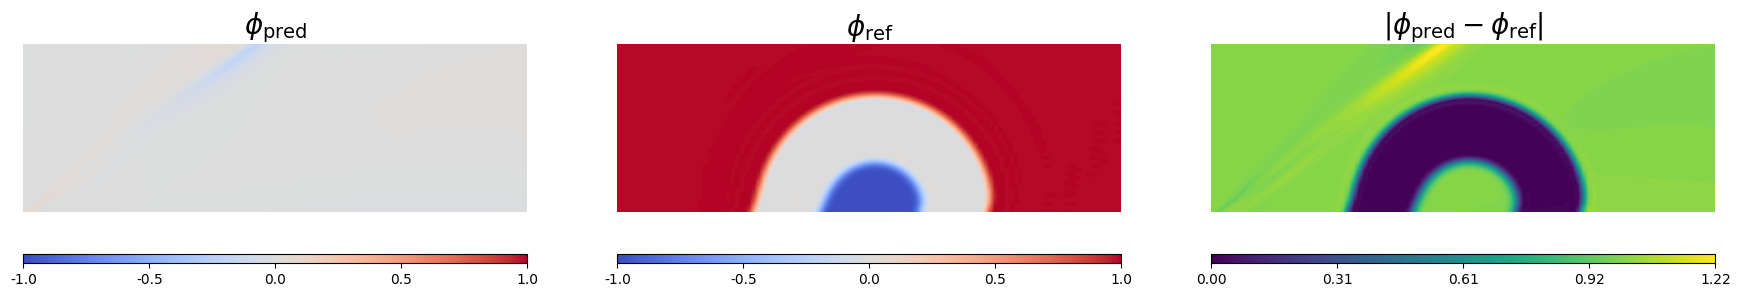

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colorbar import ColorbarBase
import torch
import os
from scipy.interpolate import griddata

# ========================= Model Prediction Code =========================
# Function to load the model
def load_model(model_path, device=None):
    """Load the trained PyTorch model
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()  # Ensure it's in evaluation mode
    return model

def get_global_model(results_dir='/content/results_dynamic_weight'):
    """Get the global model from the results directory
    """
    model_path = os.path.join(results_dir, 'dynamic_weight_model.pt')
    return load_model(model_path)

def get_model_prediction(model, grid_points, target_time, device):
    """Run model prediction on a grid of points for a specific time"""
    # Convert to tensor and move to the same device as the model
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    # Create time tensor with the specified t value (on the same device)
    t_tensor = torch.full((grid_tensor.size(0), 1), target_time, dtype=torch.float32).to(device)

    # Combine spatial and temporal inputs
    model_input = torch.cat([grid_tensor, t_tensor], dim=1)

    # Make prediction
    print("Running model prediction...")
    with torch.no_grad():
        outputs = model(model_input)

    # Check if model returns a tuple (multiple outputs)
    if isinstance(outputs, tuple):
        # Assume the first element is the phi prediction
        phi_pred = outputs[3]
    else:
        phi_pred = outputs

    # Move prediction back to CPU for numpy conversion
    return phi_pred.cpu().numpy()

# ========================= Reference Data Code =========================
def load_reference_data(file_path):
    """Load reference data from halfp*.dat file"""
    data = np.loadtxt(file_path)

    # Extract x, y, phi values
    x_coords = data[:, 0]
    y_coords = data[:, 1]
    phi_values = data[:, 3]  # phi is at column index 3

    return x_coords, y_coords, phi_values

# ========================= Main Script =========================
# Target time for prediction
target_time = 0.30
print(f"Making prediction for t = {target_time}s")

# Load the model
results_dir = '/content/results_dynamic_weight'
print(f"Loading model from {results_dir}")
model = get_global_model(results_dir)

# Get the device the model is on
device = next(model.parameters()).device
print(f"Model is on device: {device}")

# Find reference data file
snapshot_index = int(target_time / 0.03) - 1  # Adjust for 1-indexed snapshots
file_path = f"halfp{snapshot_index}.dat"
print(f"Looking for reference data at {file_path}")

# Create a common grid for both datasets
grid_size = 200
xi = np.linspace(0, 6, grid_size)
yi = np.linspace(0, 2, grid_size)
X, Y = np.meshgrid(xi, yi)
grid_points = np.vstack([X.flatten(), Y.flatten()]).T

# Get model prediction on the grid
phi_pred_flat = get_model_prediction(model, grid_points, target_time, device)
phi_pred = phi_pred_flat.reshape(X.shape)

# Check if reference file exists
if os.path.exists(file_path):
    print(f"Loading reference data from {file_path}")
    x_ref, y_ref, phi_ref_values = load_reference_data(file_path)

    print(f"Reference data shape: {phi_ref_values.shape}")
    print(f"Reference phi range: {phi_ref_values.min()} to {phi_ref_values.max()}")
    print(f"Reference x range: {x_ref.min()} to {x_ref.max()}")
    print(f"Reference y range: {y_ref.min()} to {y_ref.max()}")

    # Interpolate reference data onto the same grid as model prediction
    phi_ref = griddata((x_ref, y_ref), phi_ref_values, (X, Y), method='linear')

    # Calculate the absolute difference
    phi_diff = np.abs(phi_pred - phi_ref)

    print(f"Prediction shape: {phi_pred.shape}")
    print(f"Reference shape: {phi_ref.shape}")
    print(f"Difference shape: {phi_diff.shape}")
    print(f"Difference range: {np.nanmin(phi_diff)} to {np.nanmax(phi_diff)}")

    # Create figure with fixed size
    fig = plt.figure(figsize=(18, 3))

    # Define the size and position of each subplot
    # This gives us more control than using plt.subplots()
    left_margins = [0.05, 0.38, 0.71]  # Left positions for each subplot
    width = 0.28  # Width of each subplot

    # Define common arguments for all plots
    common_args = {
        'cmap': plt.cm.coolwarm,
        'norm': mpl.colors.Normalize(vmin=-1.0, vmax=1.0),
        'levels': 100
    }

    # Create axes for plots and colorbars with exact alignment
    axs = []
    cbar_axs = []

    for i, left in enumerate(left_margins):
        # Create main plot axis
        ax = fig.add_axes([left, 0.3, width, 0.6])
        axs.append(ax)

        # Create corresponding colorbar axis with EXACT same width
        cbar_ax = fig.add_axes([left, 0.15, width, 0.03])
        cbar_axs.append(cbar_ax)

    # Plot prediction
    cont1 = axs[0].contourf(X, Y, phi_pred, **common_args)
    axs[0].set_title(r'$\phi_{\mathrm{pred}}$', fontsize=20)

    # Plot reference
    cont2 = axs[1].contourf(X, Y, phi_ref, **common_args)
    axs[1].set_title(r'$\phi_{\mathrm{ref}}$', fontsize=20)

    # Plot absolute difference with different colormap and normalization
    diff_max = np.nanmax(phi_diff)
    diff_args = {
        'cmap': plt.cm.viridis,
        'norm': mpl.colors.Normalize(vmin=0, vmax=diff_max),
        'levels': 100
    }
    cont3 = axs[2].contourf(X, Y, phi_diff, **diff_args)
    axs[2].set_title(r'$|\phi_{\mathrm{pred}} - \phi_{\mathrm{ref}}|$', fontsize=20)

    # Format all subplots
    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Remove the spines
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Create colorbars with explicit width matching the plots
    cb1 = ColorbarBase(cbar_axs[0], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb1.set_ticks(np.linspace(-1.0, 1.0, 5))
    cb1.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])

    cb2 = ColorbarBase(cbar_axs[1], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb2.set_ticks(np.linspace(-1.0, 1.0, 5))
    cb2.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])

    cb3 = ColorbarBase(cbar_axs[2], cmap=diff_args['cmap'], norm=diff_args['norm'], orientation='horizontal')
    cb3.set_ticks(np.linspace(0, diff_max, 5))
    cb3.set_ticklabels([f'{x:.2f}' for x in np.linspace(0, diff_max, 5)])

    # Save the plot
    plt.savefig(f'phi_difference_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as 'phi_difference_t_{target_time:.2f}.png'")

    # Show the plot
    plt.show()

else:
    print(f"Reference data file {file_path} not found.")
    print("Please make sure you're in the correct directory with the data files.")

    # Check what files are available
    files = [f for f in os.listdir('.') if f.startswith('halfp') and f.endswith('.dat')]
    if files:
        print(f"Available files: {files}")
        # Find the file closest to our target time
        indices = [int(f.replace('halfp', '').replace('.dat', '')) for f in files]
        if indices:
            closest_index = min(indices, key=lambda x: abs(x - snapshot_index))
            print(f"Closest available snapshot is index {closest_index}")
            actual_time = (closest_index + 1) * 0.03
            print(f"This corresponds to time t = {actual_time:.2f}s")
            print(f"You can use halfp{closest_index}.dat as the closest available timepoint.")
    else:
        print("No halfp*.dat files found. Still plotting model prediction alone.")

        # Plot just the model prediction since we don't have reference data
        fig = plt.figure(figsize=(10, 8))

        # Create axes with explicit positioning
        plot_left = 0.1
        plot_width = 0.8

        main_ax = fig.add_axes([plot_left, 0.3, plot_width, 0.6])
        contour = main_ax.contourf(X, Y, phi_pred, 100, cmap='coolwarm',
                                  norm=mpl.colors.Normalize(vmin=-1.0, vmax=1.0))
        main_ax.set_aspect('equal')
        main_ax.set_title(r'$\phi_{\mathrm{pred}}$ at $t = ' + f'{target_time:.2f}' + 's$', fontsize=20)

        # Remove ticks and spines
        main_ax.set_xticks([])
        main_ax.set_yticks([])
        for spine in main_ax.spines.values():
            spine.set_visible(False)

        # Create colorbar with exactly the same width as the plot
        cbar_ax = fig.add_axes([plot_left, 0.15, plot_width, 0.05])

        cb = ColorbarBase(cbar_ax, cmap='coolwarm',
                         norm=mpl.colors.Normalize(vmin=-1.0, vmax=1.0), orientation='horizontal')
        cb.set_ticks(np.linspace(-1.0, 1.0, 5))
        cb.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])

        # Save the prediction-only plot
        plt.savefig(f'phi_prediction_only_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
        print(f"Prediction-only plot saved as 'phi_prediction_only_t_{target_time:.2f}.png'")

        plt.show()

Making prediction for t = 0.3s
Loading model from /content/results_dynamic_weight
Model is on device: cuda:0
Looking for reference data at half9.dat
Running model prediction...
Loading reference data from half9.dat
Reference data shape: (10000,)
Reference velocity range: 0.0 to 0.299969
Reference x range: 0.0 to 6.0
Reference y range: 0.0 to 2.0
Prediction shape: (200, 200)
Reference shape: (200, 200)
Difference shape: (200, 200)
Difference range: 0.0007080136758427918 to 0.6411423683166504
Plot saved as 'velocity_difference_t_0.30.png'


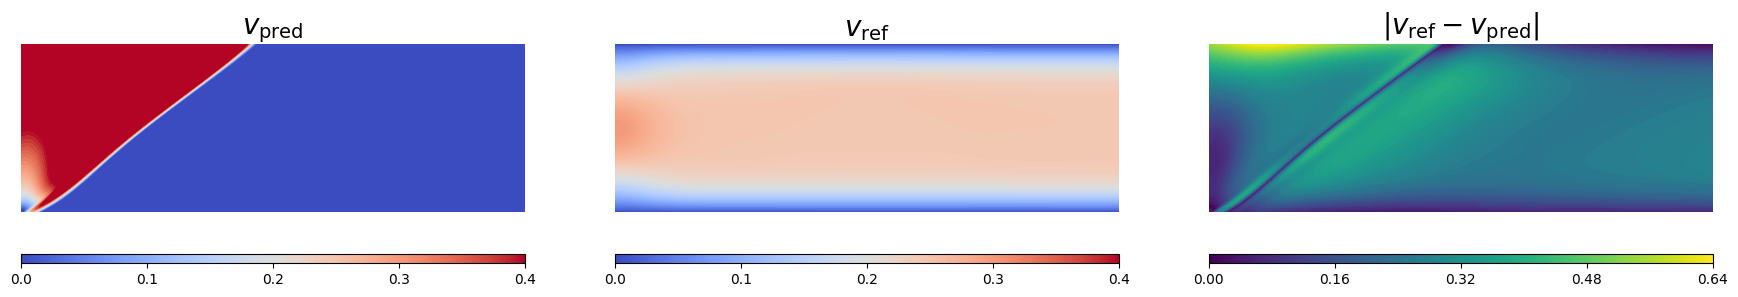

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colorbar import ColorbarBase
import torch
import os
from scipy.interpolate import griddata

# ========================= Model Prediction Code =========================
# Function to load the model
def load_model(model_path, device=None):
    """Load the trained PyTorch model
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()  # Ensure it's in evaluation mode
    return model

def get_global_model(results_dir='/content/results_dynamic_weight'):
    """Get the global model from the results directory
    """
    model_path = os.path.join(results_dir, 'dynamic_weight_model.pt')
    return load_model(model_path)

def get_model_prediction(model, grid_points, target_time, device):
    """Run model prediction on a grid of points for a specific time"""
    # Convert to tensor and move to the same device as the model
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    # Create time tensor with the specified t value (on the same device)
    t_tensor = torch.full((grid_tensor.size(0), 1), target_time, dtype=torch.float32).to(device)

    # Combine spatial and temporal inputs
    model_input = torch.cat([grid_tensor, t_tensor], dim=1)

    # Make prediction
    print("Running model prediction...")
    with torch.no_grad():
        outputs = model(model_input)

    # Check if model returns a tuple (multiple outputs)
    # In this case, we want velocity components
    if isinstance(outputs, tuple):
        # Assuming model outputs (phi, u, v) or similar order
        # We need the velocity component (assuming it's the second output)
        velocity_pred = outputs[0]  # This might need to be adjusted based on model output
    else:
        velocity_pred = outputs  # If model only outputs velocity directly

    # Move prediction back to CPU for numpy conversion
    return velocity_pred.cpu().numpy()

# ========================= Reference Data Code =========================
def load_reference_data(file_path):
    """Load reference data from half*.dat file (NOT halfp*.dat)"""
    data = np.loadtxt(file_path)

    # Extract x, y, velocity values (u is at column index 3)
    x_coords = data[:, 0]
    y_coords = data[:, 1]
    velocity_values = data[:, 3]  # u velocity is at column index 3

    return x_coords, y_coords, velocity_values

# ========================= Main Script =========================
# Target time for prediction
target_time = 0.30
print(f"Making prediction for t = {target_time}s")

# Load the model
results_dir = '/content/results_dynamic_weight'
print(f"Loading model from {results_dir}")
model = get_global_model(results_dir)

# Get the device the model is on
device = next(model.parameters()).device
print(f"Model is on device: {device}")

# Find reference data file
snapshot_index = int(target_time / 0.03) - 1  # Adjust for 1-indexed snapshots
file_path = f"half{snapshot_index}.dat"  # Use half*.dat instead of halfp*.dat
print(f"Looking for reference data at {file_path}")

# Create a common grid for both datasets
grid_size = 200
xi = np.linspace(0, 6, grid_size)
yi = np.linspace(0, 2, grid_size)
X, Y = np.meshgrid(xi, yi)
grid_points = np.vstack([X.flatten(), Y.flatten()]).T

# Get model prediction on the grid
velocity_pred_flat = get_model_prediction(model, grid_points, target_time, device)
velocity_pred = velocity_pred_flat.reshape(X.shape)

# Check if reference file exists
if os.path.exists(file_path):
    print(f"Loading reference data from {file_path}")
    x_ref, y_ref, velocity_ref_values = load_reference_data(file_path)

    print(f"Reference data shape: {velocity_ref_values.shape}")
    print(f"Reference velocity range: {velocity_ref_values.min()} to {velocity_ref_values.max()}")
    print(f"Reference x range: {x_ref.min()} to {x_ref.max()}")
    print(f"Reference y range: {y_ref.min()} to {y_ref.max()}")

    # Interpolate reference data onto the same grid as model prediction
    velocity_ref = griddata((x_ref, y_ref), velocity_ref_values, (X, Y), method='linear')

    # Calculate the absolute difference
    velocity_diff = np.abs(velocity_pred - velocity_ref)

    print(f"Prediction shape: {velocity_pred.shape}")
    print(f"Reference shape: {velocity_ref.shape}")
    print(f"Difference shape: {velocity_diff.shape}")
    print(f"Difference range: {np.nanmin(velocity_diff)} to {np.nanmax(velocity_diff)}")

    # Create figure with fixed size
    fig = plt.figure(figsize=(18, 3))

    # Define the size and position of each subplot
    # This gives us more control than using plt.subplots()
    left_margins = [0.05, 0.38, 0.71]  # Left positions for each subplot
    width = 0.28  # Width of each subplot

    # Define normalization range from the second code
    # Using the same range of 0.0 to 0.4 for velocity as in the second file
    common_args = {
        'cmap': plt.cm.coolwarm,
        'norm': mpl.colors.Normalize(vmin=0.0, vmax=0.4),
        'levels': 100
    }

    # Create axes for plots and colorbars with exact alignment
    axs = []
    cbar_axs = []

    for i, left in enumerate(left_margins):
        # Create main plot axis
        ax = fig.add_axes([left, 0.3, width, 0.6])
        axs.append(ax)

        # Create corresponding colorbar axis with EXACT same width
        cbar_ax = fig.add_axes([left, 0.15, width, 0.03])
        cbar_axs.append(cbar_ax)

    # Plot prediction
    cont1 = axs[0].contourf(X, Y, velocity_pred, **common_args)
    axs[0].set_title(r'$v_{\mathrm{pred}}$', fontsize=20)

    # Plot reference
    cont2 = axs[1].contourf(X, Y, velocity_ref, **common_args)
    axs[1].set_title(r'$v_{\mathrm{ref}}$', fontsize=20)

    # Plot absolute difference with different colormap and normalization
    diff_max = np.nanmax(velocity_diff)
    diff_args = {
        'cmap': plt.cm.viridis,
        'norm': mpl.colors.Normalize(vmin=0, vmax=diff_max),
        'levels': 100
    }
    cont3 = axs[2].contourf(X, Y, velocity_diff, **diff_args)
    axs[2].set_title(r'$|v_{\mathrm{ref}} - v_{\mathrm{pred}}|$', fontsize=20)

    # Format all subplots
    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Remove the spines
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Create colorbars with explicit width matching the plots
    cb1 = ColorbarBase(cbar_axs[0], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb1.set_ticks(np.linspace(0.0, 0.4, 5))
    cb1.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4'])

    cb2 = ColorbarBase(cbar_axs[1], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb2.set_ticks(np.linspace(0.0, 0.4, 5))
    cb2.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4'])

    cb3 = ColorbarBase(cbar_axs[2], cmap=diff_args['cmap'], norm=diff_args['norm'], orientation='horizontal')
    cb3.set_ticks(np.linspace(0, diff_max, 5))
    cb3.set_ticklabels([f'{x:.2f}' for x in np.linspace(0, diff_max, 5)])

    # Save the plot
    plt.savefig(f'velocity_difference_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as 'velocity_difference_t_{target_time:.2f}.png'")

    # Show the plot
    plt.show()

else:
    print(f"Reference data file {file_path} not found.")
    print("Please make sure you're in the correct directory with the data files.")

    # Check what files are available
    files = [f for f in os.listdir('.') if f.startswith('half') and not f.startswith('halfp') and f.endswith('.dat')]
    if files:
        print(f"Available files: {files}")
        # Find the file closest to our target time
        indices = [int(f.replace('half', '').replace('.dat', '')) for f in files]
        if indices:
            closest_index = min(indices, key=lambda x: abs(x - snapshot_index))
            print(f"Closest available snapshot is index {closest_index}")
            actual_time = (closest_index + 1) * 0.03
            print(f"This corresponds to time t = {actual_time:.2f}s")
            print(f"You can use half{closest_index}.dat as the closest available timepoint.")
    else:
        print("No half*.dat files found. Still plotting model prediction alone.")

        # Plot just the model prediction since we don't have reference data
        fig = plt.figure(figsize=(10, 8))

        # Create axes with explicit positioning
        plot_left = 0.1
        plot_width = 0.8

        main_ax = fig.add_axes([plot_left, 0.3, plot_width, 0.6])
        contour = main_ax.contourf(X, Y, velocity_pred, 100, cmap='coolwarm',
                                  norm=mpl.colors.Normalize(vmin=0.0, vmax=0.4))
        main_ax.set_aspect('equal')
        main_ax.set_title(r'$v_{\mathrm{pred}}$ at $t = ' + f'{target_time:.2f}' + 's$', fontsize=20)

        # Remove ticks and spines
        main_ax.set_xticks([])
        main_ax.set_yticks([])
        for spine in main_ax.spines.values():
            spine.set_visible(False)

        # Create colorbar with exactly the same width as the plot
        cbar_ax = fig.add_axes([plot_left, 0.15, plot_width, 0.05])

        cb = ColorbarBase(cbar_ax, cmap='coolwarm',
                         norm=mpl.colors.Normalize(vmin=0.0, vmax=0.4), orientation='horizontal')
        cb.set_ticks(np.linspace(0.0, 0.4, 5))
        cb.set_ticklabels(['0.0', '0.1', '0.2', '0.3', '0.4'])

        # Save the prediction-only plot
        plt.savefig(f'velocity_prediction_only_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
        print(f"Prediction-only plot saved as 'velocity_prediction_only_t_{target_time:.2f}.png'")

        plt.show()

Making prediction for t = 0.3s
Loading model from /content/results_dynamic_weight
Model is on device: cuda:0
Looking for reference data at half9.dat
Running model prediction...
Loading reference data from half9.dat
Reference data shape: (10000,)
Reference pressure range: 0.0 to 0.564018
Reference x range: 0.0 to 6.0
Reference y range: 0.0 to 2.0
Prediction shape: (200, 200)
Reference shape: (200, 200)
Difference shape: (200, 200)
Difference range: 8.71404063695902e-06 to 1.7210641580836963
Plot saved as 'pressure_difference_t_0.30.png'


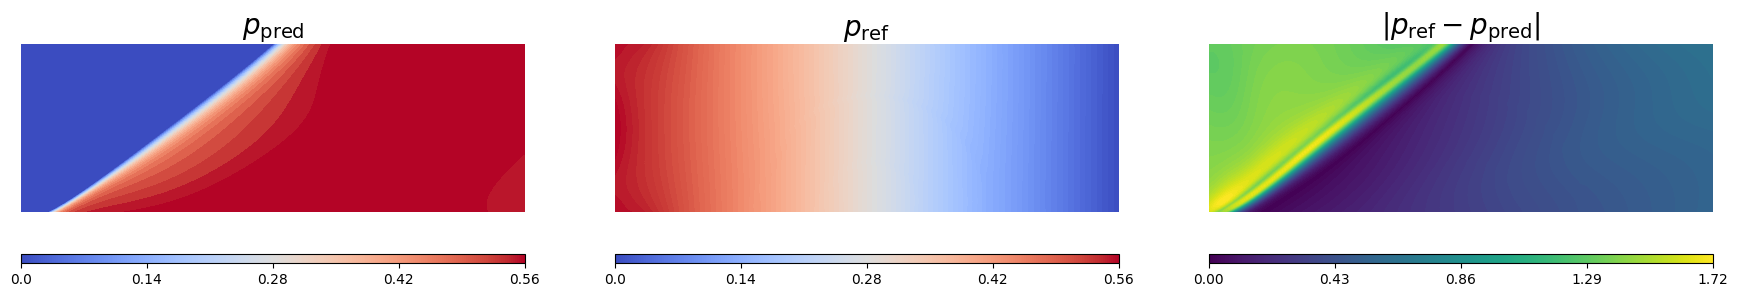

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colorbar import ColorbarBase
import torch
import os
from scipy.interpolate import griddata

# ========================= Model Prediction Code =========================
# Function to load the model
def load_model(model_path, device=None):
    """Load the trained PyTorch model
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()  # Ensure it's in evaluation mode
    return model

def get_global_model(results_dir='/content/results_dynamic_weight'):
    """Get the global model from the results directory
    """
    model_path = os.path.join(results_dir, 'dynamic_weight_model.pt')
    return load_model(model_path)

def get_model_prediction(model, grid_points, target_time, device):
    """Run model prediction on a grid of points for a specific time"""
    # Convert to tensor and move to the same device as the model
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    # Create time tensor with the specified t value (on the same device)
    t_tensor = torch.full((grid_tensor.size(0), 1), target_time, dtype=torch.float32).to(device)

    # Combine spatial and temporal inputs
    model_input = torch.cat([grid_tensor, t_tensor], dim=1)

    # Make prediction
    print("Running model prediction...")
    with torch.no_grad():
        outputs = model(model_input)

    # Check if model returns a tuple (multiple outputs)
    # In this case, we want pressure component
    if isinstance(outputs, tuple):
        # Assuming model outputs (phi, u, v, p) or similar order
        # We need the pressure component (assuming it's the last output)
        pressure_pred = outputs[2]  # This might need to be adjusted based on model output
    else:
        pressure_pred = outputs  # If model only outputs pressure directly

    # Move prediction back to CPU for numpy conversion
    return pressure_pred.cpu().numpy()

# ========================= Reference Data Code =========================
def load_reference_data(file_path):
    """Load reference data from half*.dat file (NOT halfp*.dat)"""
    data = np.loadtxt(file_path)

    # Extract x, y, pressure values (p is at column index 6)
    x_coords = data[:, 0]
    y_coords = data[:, 1]
    pressure_values = data[:, 6]  # pressure is at column index 6

    return x_coords, y_coords, pressure_values

# ========================= Main Script =========================
# Target time for prediction
target_time = 0.30
print(f"Making prediction for t = {target_time}s")

# Load the model
results_dir = '/content/results_dynamic_weight'
print(f"Loading model from {results_dir}")
model = get_global_model(results_dir)

# Get the device the model is on
device = next(model.parameters()).device
print(f"Model is on device: {device}")

# Find reference data file
snapshot_index = int(target_time / 0.03) - 1  # Adjust for 1-indexed snapshots
file_path = f"half{snapshot_index}.dat"  # Use half*.dat instead of halfp*.dat
print(f"Looking for reference data at {file_path}")

# Create a common grid for both datasets
grid_size = 200
xi = np.linspace(0, 6, grid_size)
yi = np.linspace(0, 2, grid_size)
X, Y = np.meshgrid(xi, yi)
grid_points = np.vstack([X.flatten(), Y.flatten()]).T

# Get model prediction on the grid
pressure_pred_flat = get_model_prediction(model, grid_points, target_time, device)
pressure_pred = pressure_pred_flat.reshape(X.shape)

# Check if reference file exists
if os.path.exists(file_path):
    print(f"Loading reference data from {file_path}")
    x_ref, y_ref, pressure_ref_values = load_reference_data(file_path)

    print(f"Reference data shape: {pressure_ref_values.shape}")
    print(f"Reference pressure range: {pressure_ref_values.min()} to {pressure_ref_values.max()}")
    print(f"Reference x range: {x_ref.min()} to {x_ref.max()}")
    print(f"Reference y range: {y_ref.min()} to {y_ref.max()}")

    # Interpolate reference data onto the same grid as model prediction
    pressure_ref = griddata((x_ref, y_ref), pressure_ref_values, (X, Y), method='linear')

    # Calculate the absolute difference
    pressure_diff = np.abs(pressure_pred - pressure_ref)

    print(f"Prediction shape: {pressure_pred.shape}")
    print(f"Reference shape: {pressure_ref.shape}")
    print(f"Difference shape: {pressure_diff.shape}")
    print(f"Difference range: {np.nanmin(pressure_diff)} to {np.nanmax(pressure_diff)}")

    # Create figure with fixed size
    fig = plt.figure(figsize=(18, 3))

    # Define the size and position of each subplot
    # This gives us more control than using plt.subplots()
    left_margins = [0.05, 0.38, 0.71]  # Left positions for each subplot
    width = 0.28  # Width of each subplot

    # Define normalization range from the second code
    # Using the same range of 0.0 to 0.56 for pressure as in the second file
    common_args = {
        'cmap': plt.cm.coolwarm,
        'norm': mpl.colors.Normalize(vmin=0.0, vmax=0.56),
        'levels': 100
    }

    # Create axes for plots and colorbars with exact alignment
    axs = []
    cbar_axs = []

    for i, left in enumerate(left_margins):
        # Create main plot axis
        ax = fig.add_axes([left, 0.3, width, 0.6])
        axs.append(ax)

        # Create corresponding colorbar axis with EXACT same width
        cbar_ax = fig.add_axes([left, 0.15, width, 0.03])
        cbar_axs.append(cbar_ax)

    # Plot prediction
    cont1 = axs[0].contourf(X, Y, pressure_pred, **common_args)
    axs[0].set_title(r'$p_{\mathrm{pred}}$', fontsize=20)

    # Plot reference
    cont2 = axs[1].contourf(X, Y, pressure_ref, **common_args)
    axs[1].set_title(r'$p_{\mathrm{ref}}$', fontsize=20)

    # Plot absolute difference with different colormap and normalization
    diff_max = np.nanmax(pressure_diff)
    diff_args = {
        'cmap': plt.cm.viridis,
        'norm': mpl.colors.Normalize(vmin=0, vmax=diff_max),
        'levels': 100
    }
    cont3 = axs[2].contourf(X, Y, pressure_diff, **diff_args)
    axs[2].set_title(r'$|p_{\mathrm{ref}} - p_{\mathrm{pred}}|$', fontsize=20)

    # Format all subplots
    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Remove the spines
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Create colorbars with explicit width matching the plots
    cb1 = ColorbarBase(cbar_axs[0], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb1.set_ticks([0.0, 0.14, 0.28, 0.42, 0.56])
    cb1.set_ticklabels(['0.0', '0.14', '0.28', '0.42', '0.56'])

    cb2 = ColorbarBase(cbar_axs[1], cmap=common_args['cmap'], norm=common_args['norm'], orientation='horizontal')
    cb2.set_ticks([0.0, 0.14, 0.28, 0.42, 0.56])
    cb2.set_ticklabels(['0.0', '0.14', '0.28', '0.42', '0.56'])

    cb3 = ColorbarBase(cbar_axs[2], cmap=diff_args['cmap'], norm=diff_args['norm'], orientation='horizontal')
    cb3.set_ticks(np.linspace(0, diff_max, 5))
    cb3.set_ticklabels([f'{x:.2f}' for x in np.linspace(0, diff_max, 5)])

    # Save the plot
    plt.savefig(f'pressure_difference_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
    print(f"Plot saved as 'pressure_difference_t_{target_time:.2f}.png'")

    # Show the plot
    plt.show()

else:
    print(f"Reference data file {file_path} not found.")
    print("Please make sure you're in the correct directory with the data files.")

    # Check what files are available
    files = [f for f in os.listdir('.') if f.startswith('half') and not f.startswith('halfp') and f.endswith('.dat')]
    if files:
        print(f"Available files: {files}")
        # Find the file closest to our target time
        indices = [int(f.replace('half', '').replace('.dat', '')) for f in files]
        if indices:
            closest_index = min(indices, key=lambda x: abs(x - snapshot_index))
            print(f"Closest available snapshot is index {closest_index}")
            actual_time = (closest_index + 1) * 0.03
            print(f"This corresponds to time t = {actual_time:.2f}s")
            print(f"You can use half{closest_index}.dat as the closest available timepoint.")
    else:
        print("No half*.dat files found. Still plotting model prediction alone.")

        # Plot just the model prediction since we don't have reference data
        fig = plt.figure(figsize=(10, 8))

        # Create axes with explicit positioning
        plot_left = 0.1
        plot_width = 0.8

        main_ax = fig.add_axes([plot_left, 0.3, plot_width, 0.6])
        contour = main_ax.contourf(X, Y, pressure_pred, 100, cmap='coolwarm',
                                  norm=mpl.colors.Normalize(vmin=0.0, vmax=0.56))
        main_ax.set_aspect('equal')
        main_ax.set_title(r'$p_{\mathrm{pred}}$ at $t = ' + f'{target_time:.2f}' + 's$', fontsize=20)

        # Remove ticks and spines
        main_ax.set_xticks([])
        main_ax.set_yticks([])
        for spine in main_ax.spines.values():
            spine.set_visible(False)

        # Create colorbar with exactly the same width as the plot
        cbar_ax = fig.add_axes([plot_left, 0.15, plot_width, 0.05])

        cb = ColorbarBase(cbar_ax, cmap='coolwarm',
                         norm=mpl.colors.Normalize(vmin=0.0, vmax=0.56), orientation='horizontal')
        cb.set_ticks([0.0, 0.14, 0.28, 0.42, 0.56])
        cb.set_ticklabels(['0.0', '0.14', '0.28', '0.42', '0.56'])

        # Save the prediction-only plot
        plt.savefig(f'pressure_prediction_only_t_{target_time:.2f}.png', dpi=300, bbox_inches='tight')
        print(f"Prediction-only plot saved as 'pressure_prediction_only_t_{target_time:.2f}.png'")

        plt.show()

In [ ]:
from google.colab import output

def play_sound():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

import time
for i in range(1000):
  play_sound()
  time.sleep(1)

KeyboardInterrupt: 